In [43]:
#Packages

import numpy as np
from amortization.amount import calculate_amortization_amount
from amortization.schedule import amortization_schedule
import matplotlib.pyplot as plt
from pyloan import pyloan
import pandas as pd
import math

In [93]:
#Assumptions

#Loan
PurchasePrice = 640000 #Dollars
DownPayment = 128000 #Dollars
LoanValue = PurchasePrice-DownPayment
LTYears = 30
LoanTerm = LTYears*12 #Months
LoanRate = 6 #Rate, as a percent

#Base Costs
MaintCosts = 6000 #Dollars per year
TaxHouse = 5000 #Dollars per year

#VariableCosts
Bills = 10 #Dollars per day (rented) Assumes 300 for fully rented month
Cleaning = 30 #Dollars per day (rented) (Is this even close to accurate?)

#Income
WeekendRate = 686 #Dollars per night
WeekdayRate = 294 # Dollars per night
PercentRentedWeekend = .98 #Rate !!For MC this is a distribution, defined in section 2
PercentRentedWeekday = .39 #Rate !!For MC this is a distribution, defined in section 2


#Constants
WeekendDaysInYear = 365/2
WeekDaysInYear = 365/5
DaysinYear = 365

In [94]:
#Calculate Loan Info

LoanPayment = calculate_amortization_amount(LoanValue, LoanRate/100, LoanTerm)

#Schedule
AS = amortization_schedule(LoanValue, LoanRate, LoanTerm)
loan = pyloan.Loan(loan_amount=LoanValue,interest_rate=LoanRate,loan_term=LTYears,start_date='2023-07-16')

In [95]:
#Populate Loan Amortization table

payment_schedule = loan.get_payment_schedule()

schedule = pd.DataFrame.from_records(loan.get_payment_schedule(),columns=pyloan.Payment._fields)

schedule = pd.DataFrame.to_numpy(schedule)  

Balances = np.zeros([LTYears])

#Get yearly numbers
i = 0

while i < 360:
    
    if i%12 == 0:
       
        Balances[int(i/12)] = schedule[i,6]
    i+=1

        

In [96]:
Income = WeekendDaysInYear*PercentRentedWeekend*WeekendRate + WeekDaysInYear*PercentRentedWeekday*WeekdayRate #Dollars
Expenses = 12*LoanPayment + MaintCosts + TaxHouse + (PercentRentedWeekend*WeekendDaysInYear + PercentRentedWeekday*WeekDaysInYear)*(Bills+Cleaning)

In [97]:
Income-Expenses #Dollars (Per year)

74932.08

# Section 2 - MonteCarlo Analysis
## 4 series are generated
### 1. Remove
### 2. Cumulative rental income
### 3. Brokerage account value, subtracting loan payment from brokerage acct, reinvesting profits back into account
### 4. Brokerage account only, beginning balance of loan value, not purchasing property


In [98]:
#Distributions
#1YrReturnS&P https://klementoninvesting.substack.com/p/the-distribution-of-stock-market
#1Yr return housing https://www.creditkarma.com/home-loans/i/average-home-value-increase-per-year
muMkt = .1
sigmaMkt = .1

#
muwkndRentPct = .98
sigmawkndRentPct = .1

muwkRentPct = .39
sigmawkRentPct = .1

muHousing = .042
sigmaHousing = .04

#initialization
iterations = 1000
YearlyData = np.zeros([iterations,LTYears,7]) #Layer(Iteration), row(Year), column(Columns = Year, BrokerageValueNoReinvest, RentalCumulativeIncome, BrokerageValueReinvest, 600kNoHouse, Property Value, Overall net worth)
YearlyData[:,0,0] = 0 #Current year 0
YearlyData[:,0,1] = 0 #Remove
YearlyData[:,0,2] = 0 #initial cumulative rental income
YearlyData[:,0,3] = 0 #InitialBrokerageAcctValue
YearlyData[:,0,4] = DownPayment #Brokerage account value only, no property purchase
YearlyData[:,0,5] = PurchasePrice #Property Value Only
YearlyData[:,0,6] = DownPayment #Combined net worth, brokerage acct value, property appreciation, current loan value subtracted. Gets 3 series added, so do not need initiate at 120
i = 0 
j = 1 # j=0 already set in initializations above

In [99]:
#income and net worth calculations

while i < iterations:
    
    j=1
    while j < (30):
        
        #increment year
        YearlyData[i,j,0] = YearlyData[i,j-1,0] + 1     #Year
    
        #Randomness for stock market
        samplemkt = np.random.normal(muMkt, sigmaMkt, size=1)
        
        #Randomness for rent%
        samplewk = np.random.normal(muwkRentPct, sigmawkRentPct, size=1)
        samplewknd = np.random.normal(muwkndRentPct, sigmawkndRentPct, size=1)
        
        #Randomness for housing market
        samplehousingmkt = np.random.normal(muHousing, sigmaHousing, size = 1)
        
        
        #Remove                                                                  
        YearlyData[i,j,1] = 0
        
        #Calculate rental cumulative income
        Income = WeekendDaysInYear*samplewknd*WeekendRate + WeekDaysInYear*samplewk*WeekdayRate #Dollars
        Expenses = 12*LoanPayment + MaintCosts + TaxHouse + (PercentRentedWeekend*WeekendDaysInYear + PercentRentedWeekday*WeekDaysInYear)*(Bills+Cleaning)

        YearlyData[i,j,2] = YearlyData[i,j-1,2] + Income-Expenses
        
        #Calculate acct value with profit Reinvestment                                                                   
        YearlyData[i,j,3] = YearlyData[i,j-1,3] + YearlyData[i,j-1,3]*samplemkt + (Income-Expenses)
        
        #Calculate brokerage acct value without rental property                                                                  
        YearlyData[i,j,4] = YearlyData[i,j-1,4] + YearlyData[i,j-1,4]*samplemkt
        
        #Property Value
        YearlyData[i,j,5] = YearlyData[i,j-1,5] + YearlyData[i,j-1,5]*samplehousingmkt
        
        
        #Calculate net worth including rental property appreciation = Acct value with profit reinvest + home value - loan balance
        YearlyData[i,j,6] = YearlyData[i,j,3] + YearlyData[i,j,5] - Balances[j]
        
        
        
        j+=1
    
    i+=1

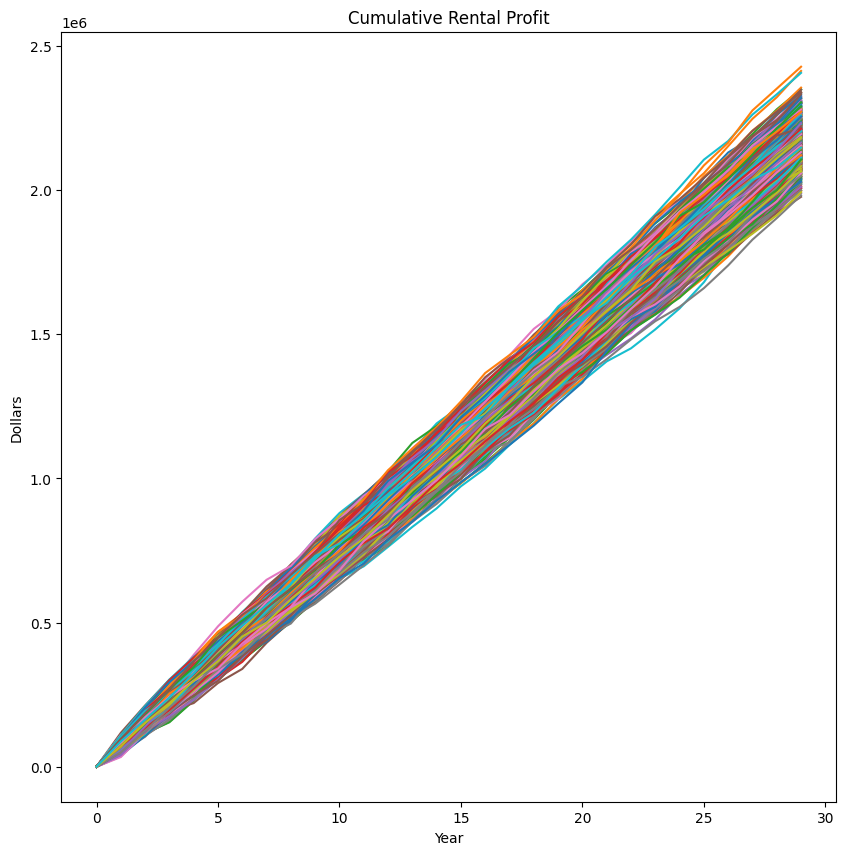

In [100]:
#Plot MonteCarlo for cumulative profit
fig = plt.figure(figsize =(10, 10))
plt.title('Cumulative Rental Profit')

for i in range(YearlyData.shape[0]):
    label = f'data{i}'   # Generate a label for the series
    plt.plot(YearlyData[i,:,0], YearlyData[i,:,2], label=label)

# Add axis labels and legend
plt.xlabel('Year')
plt.ylabel('Dollars')


# Show the plot
plt.show()

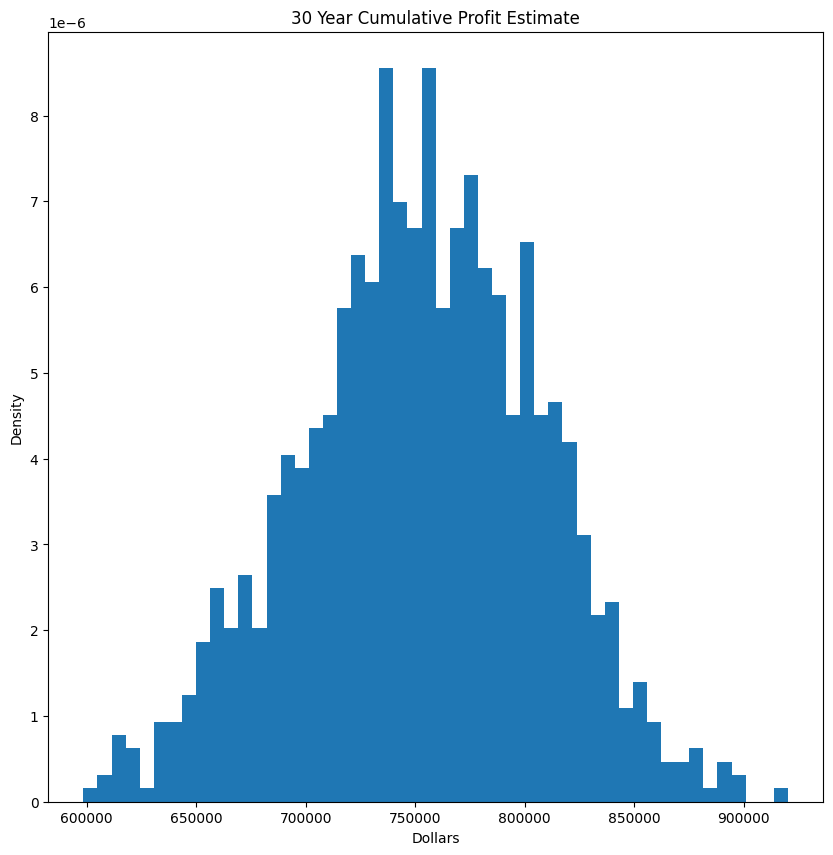

In [15]:
fig = plt.figure(figsize =(10, 10))
plt.title('30 Year Cumulative Profit Estimate')
n, bins, patches = plt.hist(YearlyData[:,29,2], bins=50, density = True)
plt.xlabel('Dollars')
plt.ylabel('Density')

bin_centers = 0.5 * (bins[1:] + bins[:-1])


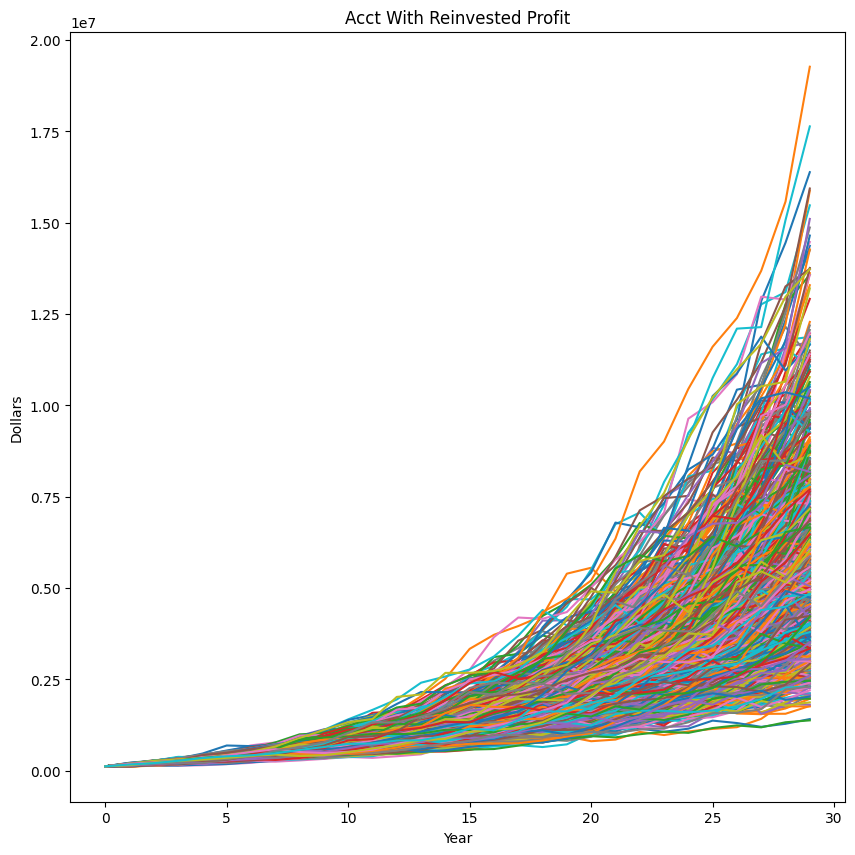

In [22]:
#Plot MonteCarlo

fig = plt.figure(figsize =(10, 10))
plt.title('Acct With Reinvested Profit')
for i in range(YearlyData.shape[0]):
    label = f'data{i}'   # Generate a label for the series
    plt.plot(YearlyData[i,:,0], YearlyData[i,:,3], label=label)

# Add axis labels and legend
plt.xlabel('Year')
plt.ylabel('Dollars')


# Show the plot
plt.show()

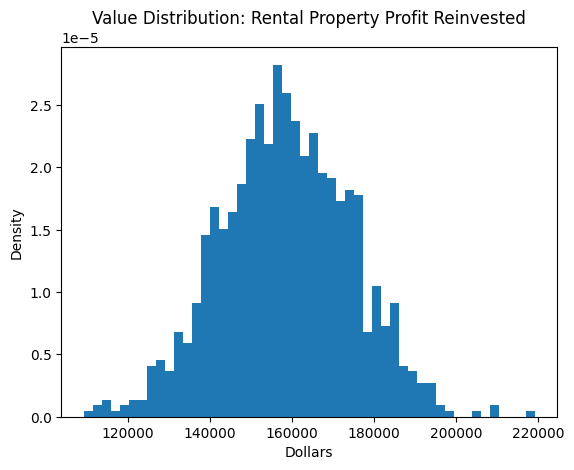

In [23]:
n, bins, patches = plt.hist(YearlyData[:,1,3], bins=50, density = True)
plt.xlabel('Dollars')
plt.ylabel('Density')
plt.title('Value Distribution: Rental Property Profit Reinvested')
bin_centers = 0.5 * (bins[1:] + bins[:-1])


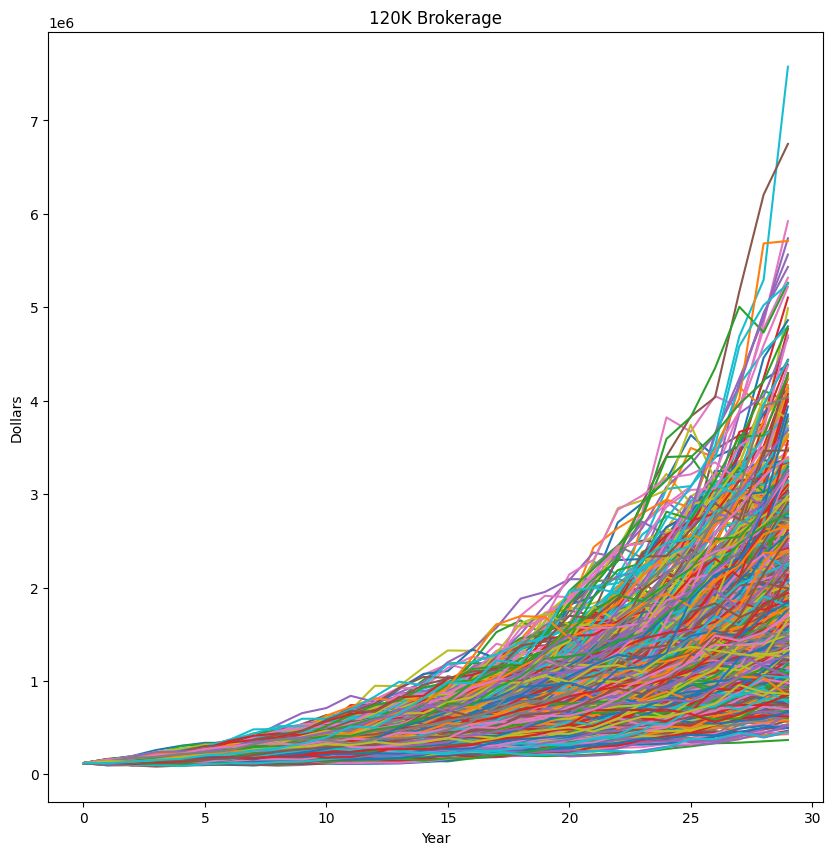

In [20]:
#Plot MonteCarlo

fig = plt.figure(figsize =(10, 10))
plt.title('120K Brokerage')
for i in range(YearlyData.shape[0]):
    label = f'data{i}'   # Generate a label for the series
    plt.plot(YearlyData[i,:,0], YearlyData[i,:,4], label=label)

# Add axis labels and legend
plt.xlabel('Year')
plt.ylabel('Dollars')


# Show the plot
plt.show()

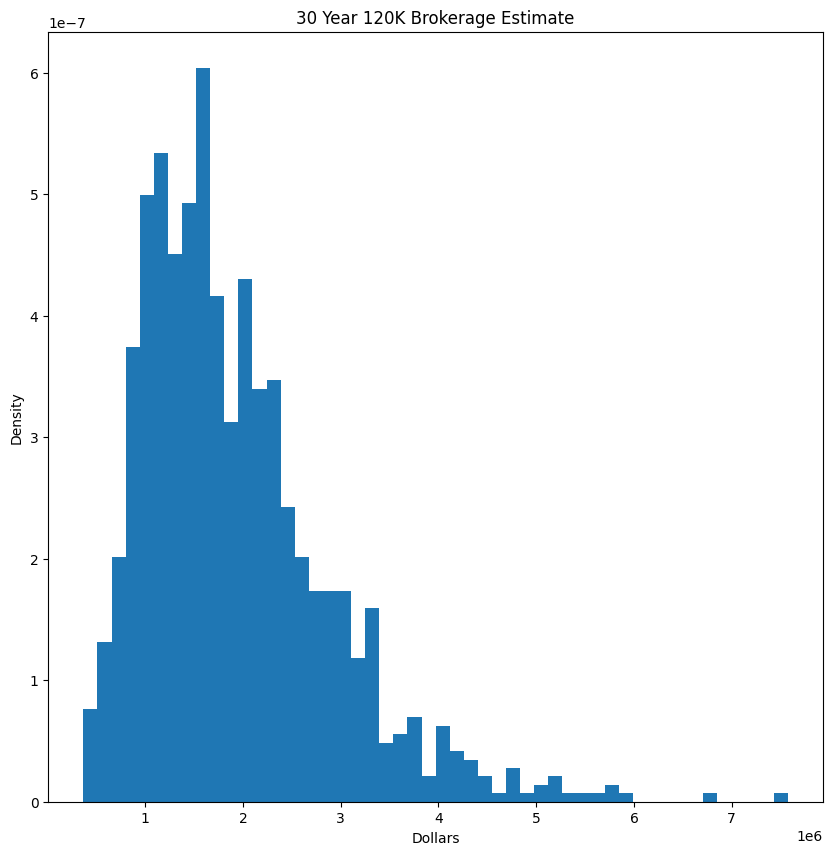

In [19]:
fig = plt.figure(figsize =(10, 10))
n, bins, patches = plt.hist(YearlyData[:,29,4], bins=50, density = True)
plt.xlabel('Dollars')
plt.ylabel('Density')
plt.title('30 Year 120K Brokerage Estimate')

bin_centers = 0.5 * (bins[1:] + bins[:-1])


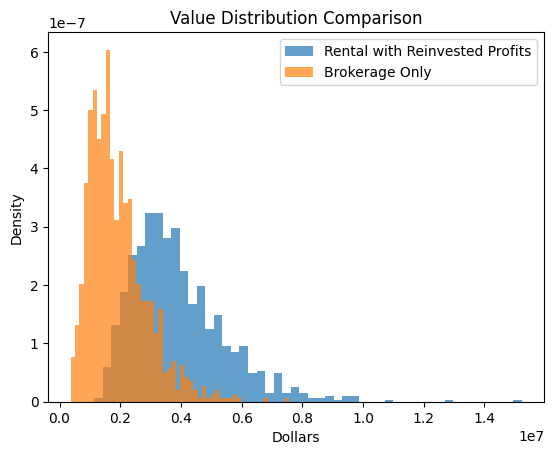

In [33]:
#Plot overlapping
plt.hist(YearlyData[:,29,3], bins=50, density = True, alpha = .7, label = 'Rental with Reinvested Profits')
plt.hist(YearlyData[:,29,4], bins=50, density = True, alpha = .7, label = 'Brokerage Only')
plt.xlabel('Dollars')
plt.ylabel('Density')
plt.title('Value Distribution Comparison')
plt.legend()

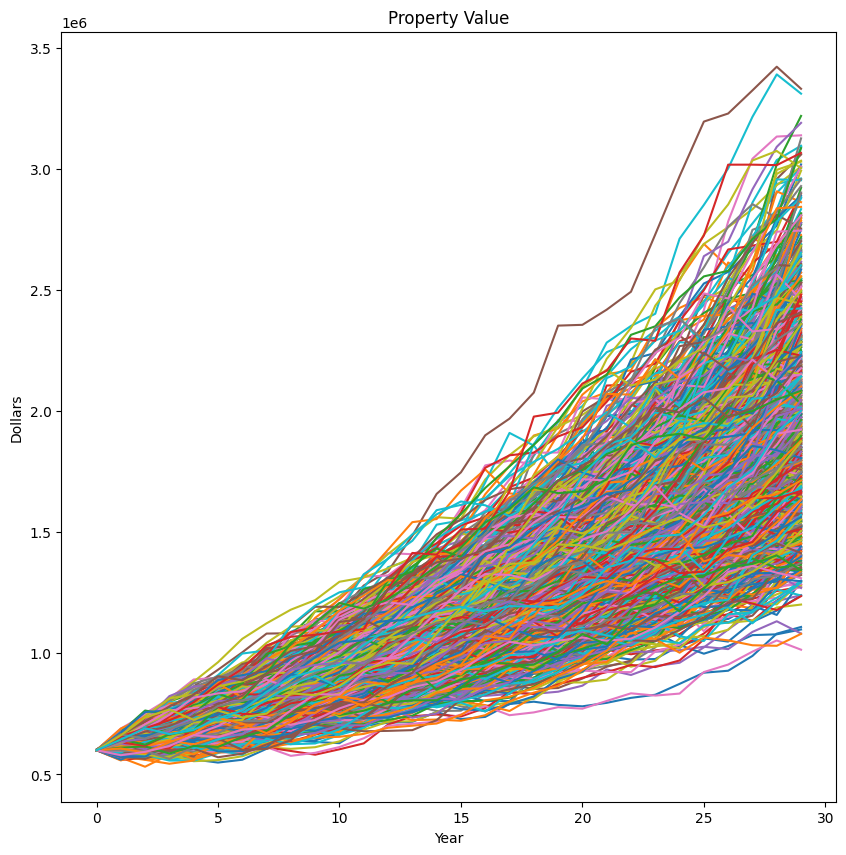

In [21]:
#Plot MonteCarlo

fig = plt.figure(figsize =(10, 10))
plt.title('Property Value')
for i in range(YearlyData.shape[0]):
    label = f'data{i}'   # Generate a label for the series
    plt.plot(YearlyData[i,:,0], YearlyData[i,:,5], label=label)

# Add axis labels and legend
plt.xlabel('Year')
plt.ylabel('Dollars')


# Show the plot
plt.show()

Text(0.5, 1.0, '30 Year Property Value Estimate')

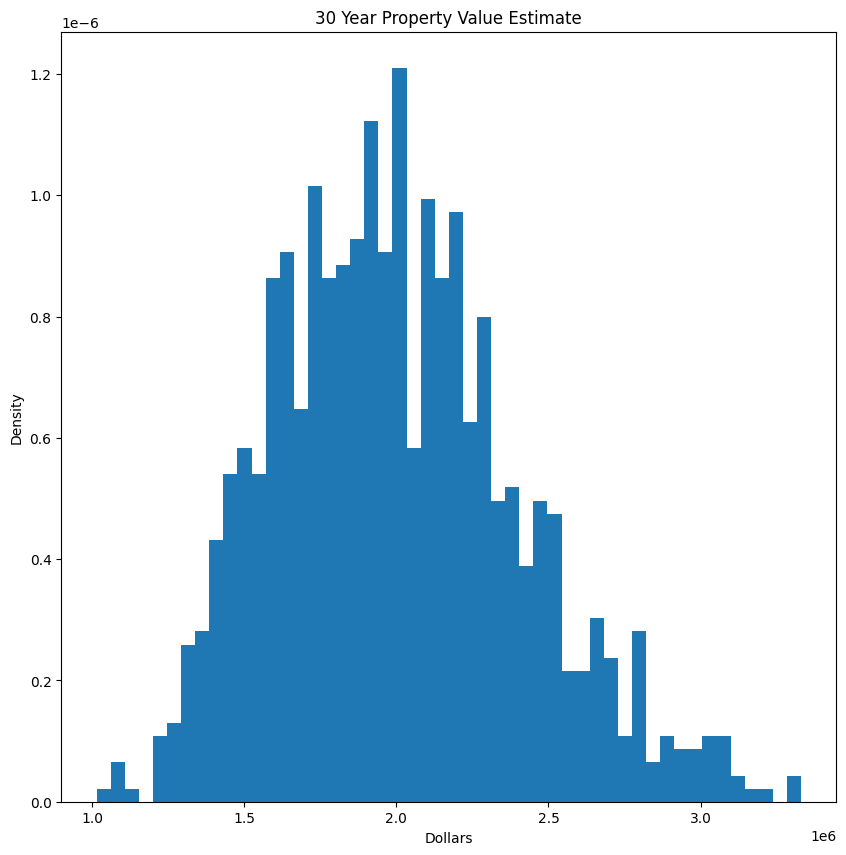

In [26]:
fig = plt.figure(figsize =(10, 10))
plt.hist(YearlyData[:,29,5], bins=50, density = True)
plt.xlabel('Dollars')
plt.ylabel('Density')
plt.title('30 Year Property Value Estimate')


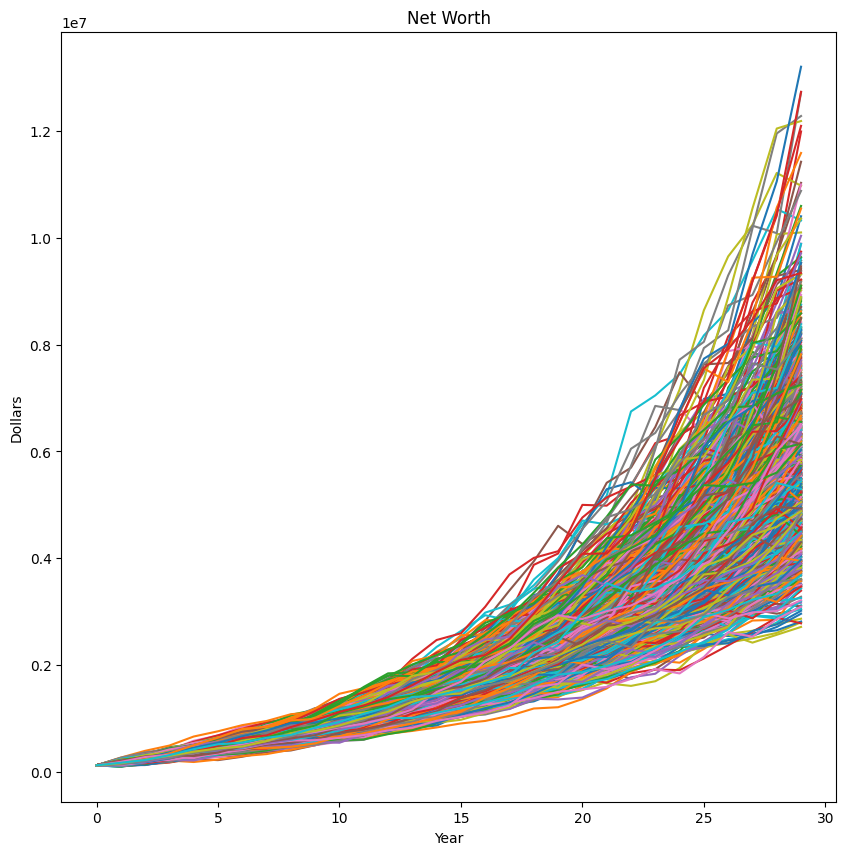

In [82]:
#Plot MonteCarlo

fig = plt.figure(figsize =(10, 10))
plt.title('Net Worth')
for i in range(YearlyData.shape[0]):
    label = f'data{i}'   # Generate a label for the series
    plt.plot(YearlyData[i,:,0], YearlyData[i,:,6], label=label)

# Add axis labels and legend
plt.xlabel('Year')
plt.ylabel('Dollars')


# Show the plot
plt.show()

Text(0.5, 1.0, '30 Year Net Worth Estimate')

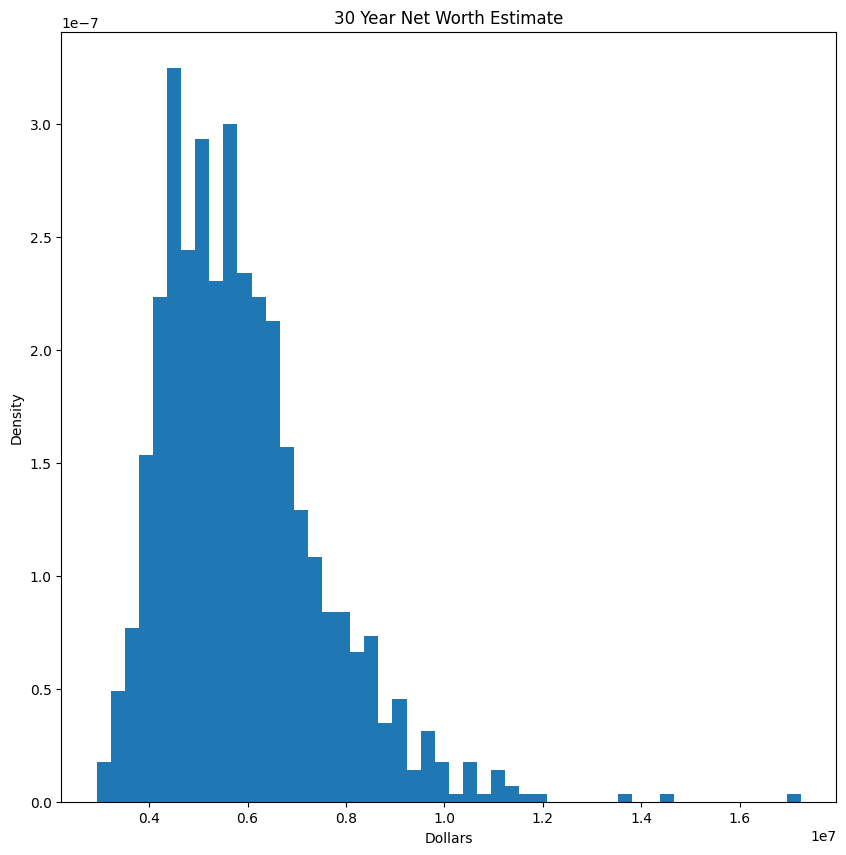

In [32]:
fig = plt.figure(figsize =(10, 10))
plt.hist(YearlyData[:,29,6], bins=50, density = True)

plt.xlabel('Dollars')
plt.ylabel('Density')
plt.title('30 Year Net Worth Estimate')


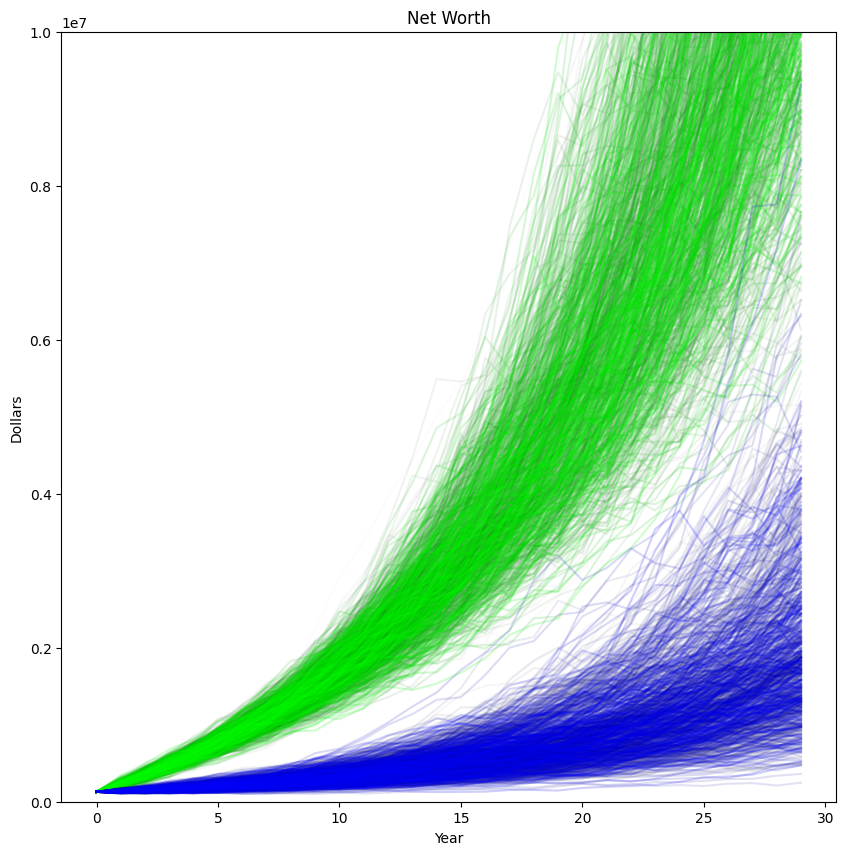

In [102]:
#Plot MonteCarlo 

fig = plt.figure(figsize =(10, 10))
plt.title('Net Worth')
for i in range(YearlyData.shape[0]):
    label = f'data{i}'   # Generate a label for the series
    plt.plot(YearlyData[i,:,0], YearlyData[i,:,6], label=label, c = [0,i/1000,0, i/5000])
for i in range(YearlyData.shape[0]):
    label = f'data{i}'   # Generate a label for the series
    plt.plot(YearlyData[i,:,0], YearlyData[i,:,4], label=label, c = [0,0,i/1000, i/5000])
    
# Add axis labels and legend
plt.xlabel('Year')
plt.ylabel('Dollars')
plt.ylim([0,10000000])

# Show the plot
plt.show()

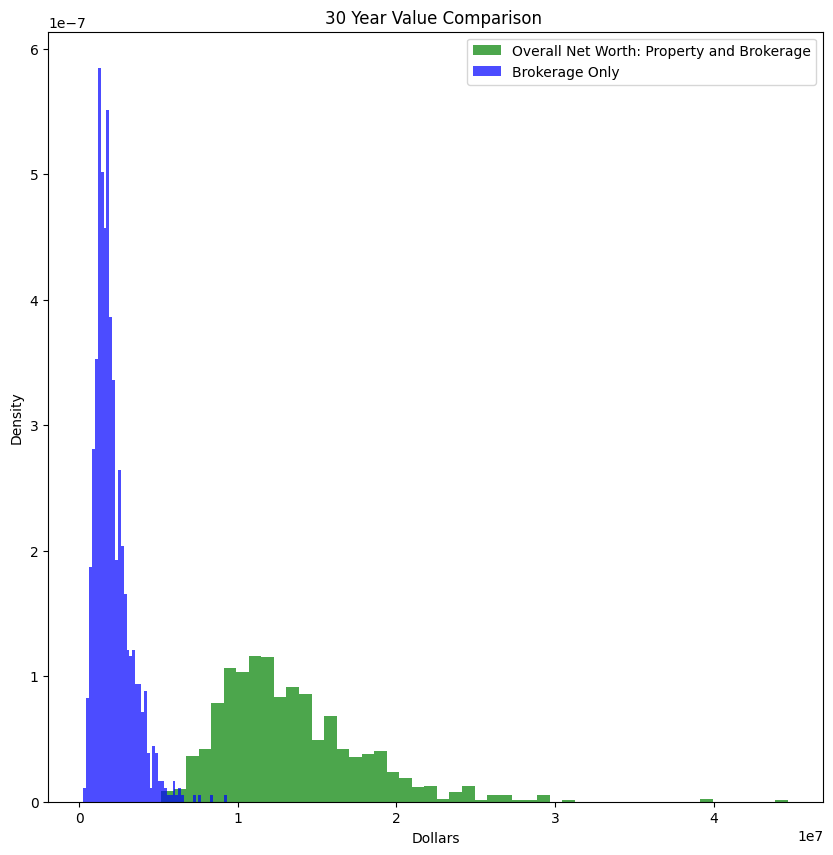

In [101]:
#Plot overlapping
fig = plt.figure(figsize =(10, 10))
plt.hist(YearlyData[:,29,6], bins=50, density = True, alpha = .7, label = 'Overall Net Worth: Property and Brokerage', color = 'green')
plt.hist(YearlyData[:,29,4], bins=50, density = True, alpha = .7, label = 'Brokerage Only', color = [0,0,1])
plt.xlabel('Dollars')
plt.ylabel('Density')
plt.title('30 Year Value Comparison ')
plt.legend()

In [ ]:
#Calculate net worth including rental property appreciation = Acct value with profit reinvest + home value - loan balance
YearlyData[i,j,6] = YearlyData[i,j,3] + YearlyData[i,j,5] - Balances[j]

#